# Install Packages

In [31]:
%pip install --quiet --upgrade --user langchain langchain-core langchain-google-vertexai google-search-results google-cloud-aiplatform

In [32]:
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

After the restart is complete, continue to the next step.



# Import Modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

import vertexai
from vertexai.preview.vision_models import ImageGenerationModel

from langchain_google_vertexai import VertexAI
from langchain import PromptTemplate
from langchain import SerpAPIWrapper
from langchain.agents import initialize_agent, Tool, load_tools
from langchain.chains import LLMChain, SequentialChain
from langchain.output_parsers import ResponseSchema, StructuredOutputParser

# Weather App

## Weather Prompt Cleaning

In [3]:
def get_reformatted_inquiry(user_input, llm):
    """
    Processes the user input to reformat it into a structured weather inquiry.

    Args:
        user_input (str): The raw input string from the user.
        llm (VertexAI): The language model used for processing the input.

    Returns:
        tuple: Contains the validity of the inquiry, reformatted inquiry, location, and date.
    """
    response_schemas = [
        ResponseSchema(
            name="valid_inquiry",
            description="A boolean describing whether or not the user input is a valid inquiry"
        ),
        ResponseSchema(
            name="reformatted_inquiry",
            description="This is your response, a reformatted inquiry asking about the weather."
        ),
        ResponseSchema(
            name="location",
            description="The location of the inquiry."
        ),
        ResponseSchema(
            name="date",
            description="The date of the inquiry."
        ),
    ]

    # Initialize the output parser with the new response schemas
    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
    format_instructions = output_parser.get_format_instructions()

    template = """
    You will be given a poorly formatted string from a user. First decide if this is a valid inquiry containing a Location and request for the weather.
    Then, reformat the user input as an inquiry for a search engine asking what the weather in the specified location is either for current, today, or a specified date.
    Make sure all the words are spelled correctly, including country, city, and state names, and dates.
    Provide the reformatted inquiry as well as the location and the specific date described.
    The inquiry should request information from a search engine on the weather including the sky description, temperature information,
    precipitation information, humidity information, and wind information.

    {format_instructions}

    # % USER INPUT:
    {user_input}

    YOUR RESPONSE:
    - Valid Inquiry:
    - Reformatted Inquiry:
    - Location:
    - Date:

    """
    prompt = PromptTemplate(
        input_variables=["user_input"],
        partial_variables={"format_instructions": format_instructions},
        template=template,
    )

    # Generate the parsed output
    promptValue = prompt.format(user_input=user_input)
    llm_output = llm(promptValue)
    parsed_output = output_parser.parse(llm_output)

    valid_inquiry = parsed_output['valid_inquiry']
    reformatted_inquiry = parsed_output['reformatted_inquiry']
    location = parsed_output['location']
    date = parsed_output['date']

    return valid_inquiry, reformatted_inquiry, location, date

## Weather LLM Agent

In [4]:
def get_weather_info(weather_inquiry, tool_selection, llm):
    """
    Generates a detailed weather report based on a specified weather inquiry using a selected tool and a language model.

    This function dynamically generates a prompt based on the user's weather inquiry, utilizes a specified tool
    (e.g., SerpAPI or OpenWeatherMap) for fetching weather data, and leverages a language model to interpret and
    format the weather data into a structured report. The report includes details such as sky description,
    temperature, precipitation, humidity, and wind information.

    Args:
        weather_inquiry (str): The user's query about the weather, which could include location and date.
        tool_selection (str): The tool selected for fetching weather data. Valid options include "SerpAPI" and "OpenWeatherMap".
        llm (LLM): The language model used for processing the weather inquiry and generating the structured weather report.

    Returns:
        dict: A dictionary containing structured information about the weather report, including:
              - weather_report (str): A detailed description of the weather.
              - sky_description (str): Description of the sky conditions.
              - high_temperature (str): The high temperature for the specified location and date.
              - low_temperature (str): The low temperature for the specified location and date.
              - temperature_units (str): Units of measurement for the temperature.
              - precipitation (str): Information about precipitation.
              - humidity (str): The relative humidity.
              - wind_speed (str): The wind speed.
              - wind_direction (str): The wind direction.

    The function initializes an agent with the selected tool for fetching weather data and constructs a prompt template
    for the language model to generate a detailed weather report based on the weather inquiry. It uses structured
    output parsing to extract and format specific details from the model's response into a structured dictionary.
    """
    response_schemas = [
        ResponseSchema(
            name="weather_report",
            description="This is a detailed explanation of the weather including a description of the sky, high temperature, low temperature, and chance of rain."
        ),
        ResponseSchema(
            name="sky_description",
            description="This is a description of the sky, cloudy or clear the sky is for the specified location and date."
        ),
        ResponseSchema(
            name="high_temperature",
            description="This is the high temperatures for the specified location and date."
        ),
        ResponseSchema(
            name="low_temperature",
            description="This is the low temperature for the specified location and date."
        ),
        ResponseSchema(
            name="temperature_units",
            description="This is the units of measurement for the temperature for the specified location and date."
        ),
        ResponseSchema(
            name="precipitation",
            description="This is the information about precipitation, such as rain, snow, sleet, ice, hail, and drizzle for the specified location and date."
        ),
        ResponseSchema(
            name="humidity",
            description="This is the relative humidity for the specified location and date."
        ),
        ResponseSchema(
            name="wind_speed",
            description="This is the wind speed for the specified location and date."
        ),
        ResponseSchema(
            name="wind_direction",
            description="This is the wind direction for the specified location and date."
        ),
    ]

    # Initialize the output parser with the new response schemas
    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

    # Get format instructions for the new response schemas
    format_instructions = output_parser.get_format_instructions()

    template = """
    {weather_inquiry}.
    Please provide a detailed explanation of the weather including the sky description, temperature information,
    precipitation information, humidity information, and wind information. The High temperature and the low temperature are very important.

    {format_instructions}

    % USER INPUT:
    {weather_inquiry}

    YOUR RESPONSE:
    - Weather Report:
    - Sky Description:
    - High Temperature:
    - Low Temperature:
    - Temperature units:
    - Precipitation:
    - Humidity:
    - Wind Speed:
    - Wind Direction:
    """

    prompt = PromptTemplate(
        input_variables=["weather_inquiry"],
        partial_variables={"format_instructions": format_instructions},
        template=template,
    )

    # Define tools for LLM weather agent
    tools = []
    if tool_selection == "SerpAPI":
        search = SerpAPIWrapper()
        tools.append(Tool(name="Search", func=search.run, description="Useful for answering current event questions."))

    elif tool_selection == "OpenWeatherMap":
        tools.append(load_tools(["openweathermap-api"], llm))

    # Initialize agent and process output
    agent = initialize_agent(tools=tools, llm=llm, agent="chat-zero-shot-react-description", verbose=True)
    agent_output = agent.run(prompt.format_prompt(weather_inquiry=weather_inquiry))

    weather_info = output_parser.parse(agent_output)


    return weather_info

## Weather Image Prompt Generation

In [5]:
def get_weather_image_prompt(weather_report, location, llm):
    """
    Creates a prompt for generating an image based on the weather report and location.

    Args:
        weather_report (str): The detailed weather report.
        location (str): The location of the weather inquiry.
        llm (VertexAI): The language model used for creating the image prompt.

    Returns:
        str: The prompt for image generation.
    """
    # Weather Image Prompt Generation
    prompt_template_weather_image = PromptTemplate(
        input_variables=['weather_report', 'location'],
        template="""
        {weather_report}. Please create an image generation prompt for a scene describing this weather report in {location}.
        Please include a cartoon character in the foreground of the scene enjoying the weather. The overall style of the image being consistent.
        """
    )

    # Initialize LLM weather chain
    llm_weather_image_chain = LLMChain(llm=llm, prompt=prompt_template_weather_image)

    weather_image_prompt = llm_weather_image_chain({'weather_report': weather_report,
                                                    'location': location})['text']

    return weather_image_prompt

# Testing:

In [6]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=""

PROJECT_ID = "" # use your project id
REGION = "us-central1"  #
BUCKET_URI = f""  # create your own bucket

vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

In [7]:
model_list = ["gemini-pro","text-bison@001", "text-bison@002"]
model_selection = model_list[0]
# Initialize models
llm = VertexAI(
    model_name=model_selection,
    max_output_tokens=512,
    temperature=0.5,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

generation_model = ImageGenerationModel.from_pretrained("imagegeneration@005")

In [8]:
tool_list = ["SerpAPI", "OpenWeatherMap"]
tool_selection = tool_list[0]

with open("/SerpApi_Key.txt", "r") as file:
  serp_api_key = file.read().rstrip()

os.environ["SERPAPI_API_KEY"] = serp_api_key

In [66]:
user_input = "what it lik in ne york torrow"

In [67]:
valid_inquiry, reformatted_inquiry, location, date = get_reformatted_inquiry(user_input, llm)

In [68]:
print("valid_inquiry: ", valid_inquiry)
print("reformatted_inquiry: ", reformatted_inquiry)
print("location: ", location)
print("date: ", date)

valid_inquiry:  True
reformatted_inquiry:  What is the weather in New York City, New York tomorrow?
location:  New York City, New York
date:  tomorrow


In [69]:
weather_info = get_weather_info(reformatted_inquiry, tool_selection, llm)



> Entering new AgentExecutor chain...
Thought: I should use the search tool to find the weather in New York City tomorrow.
Action:
```
{
  "action": "Search",
  "action_input": {
    "query": "weather in New York City, New York tomorrow"
  }
}
```

Observation: {'type': 'weather_result', 'temperature': '42', 'unit': 'Fahrenheit', 'precipitation': '0%', 'humidity': '42%', 'wind': '13 mph', 'location': 'New York, NY', 'date': 'Friday', 'weather': 'Partly cloudy'}
Thought:Action:
```
{
  "action": "Search",
  "action_input": {
    "query": "weather in New York City, New York tomorrow"
  }
}
```


Observation: {'type': 'weather_result', 'temperature': '42', 'unit': 'Fahrenheit', 'precipitation': '0%', 'humidity': '42%', 'wind': '13 mph', 'location': 'New York, NY', 'date': 'Friday', 'weather': 'Partly cloudy'}
Thought:The weather in New York City, New York tomorrow is partly cloudy with a high of 42 degrees Fahrenheit and a low of 32 degrees Fahrenheit. There is a 0% chance of precipitat

In [70]:
for k in weather_info:
  print(f'{k}: {weather_info[k]} \n')

weather_report: The weather in New York City, New York tomorrow is partly cloudy with a high of 42 degrees Fahrenheit and a low of 32 degrees Fahrenheit. There is a 0% chance of precipitation and the humidity is 42%. The wind speed is 13 mph and the wind direction is from the west. 

sky_description: Partly cloudy 

high_temperature: 42 

low_temperature: 32 

temperature_units: Fahrenheit 

precipitation: 0% 

humidity: 42% 

wind_speed: 13 mph 

wind_direction: west 



In [71]:
weather_report = weather_info["weather_report"]
weather_image_prompt = get_weather_image_prompt(weather_report, location, llm)
print(weather_image_prompt)

**Image Generation Prompt:**

Create an idyllic scene of New York City, New York on a partly cloudy day with a high of 42 degrees Fahrenheit and a low of 32 degrees Fahrenheit. The sky should be a mix of white clouds and blue sky.

In the foreground, a cheerful cartoon character should be enjoying the weather. They should be wearing a warm coat, hat, and gloves, and their face should be filled with joy. The character should be standing in front of a famous New York City landmark, such as the Empire State Building or the Statue of Liberty.

The overall style of the image should be bright and inviting, capturing the beauty of a crisp autumn day in New York City.


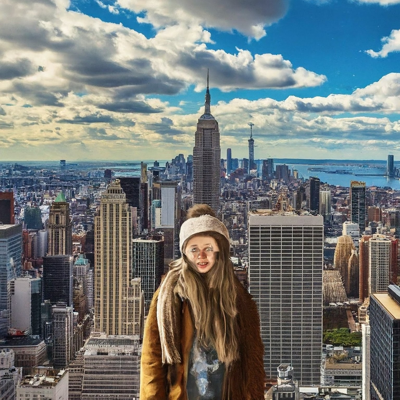

In [72]:
weather_image = generation_model.generate_images(prompt=weather_image_prompt)
resized_image = weather_image.images[0]._pil_image.resize((400, 400))
resized_image

##  Image Generation Accuracy Evaluation:
  - GPT4 evaluation of Imagen2 adherence to weather_image_prompt

In [13]:
from io import BytesIO
import base64
import requests

os.environ["OPENAI_API_KEY"] = ""
api_key = os.getenv("OPENAI_API_KEY")

In [14]:
def query_openai(payload):
    """Sends a request to the OpenAI API and prints the response."""
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()

In [15]:
def encode_pil_image(pil_image):
    """Encodes a PIL image to base64 and determines the correct MIME type."""
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can adjust the format as needed
    mime_type = "image/jpeg"  # Adjust if using a different format
    encoded_string = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return f"data:{mime_type};base64,{encoded_string}"

In [16]:
def create_payload(pil_images, prompt, model="gpt-4-vision-preview", max_tokens=100, detail="high"):
    """Creates the payload for the API request using in-memory PIL images."""
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt,
                },
            ],
        },
    ]

    for pil_image in pil_images:
        base64_image = encode_pil_image(pil_image)
        messages[0]["content"].append({
            "type": "image_url",
            "image_url": {
                "url": base64_image,
                "detail": detail,
            }
        })

    return {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens
    }

In [17]:
def evaluate_weather_images_with_gpt4(evaluation_prompt_template, weather_image_prompt, resized_image):
  # Format the evaluation prompt with the specific weather_image_prompt
  evaluation_prompt = evaluation_prompt_template.format(weather_image_prompt)

  # Assuming `resized_image` is a PIL image
  pil_images = [resized_image]  # This example works with one image, adjust as needed

  # Create payload with the evaluation prompt
  payload = create_payload(pil_images, evaluation_prompt)

  # Query OpenAI (ensure your API key is set in your environment variables)
  response = query_openai(payload)

  return response.get("choices")[0].get("message").get("content")

In [18]:
def get_evaluation_score(evaluation, llm):
    """
    Args:
        evaluation (str): The raw input string from the user.
        llm (VertexAI): The language model used for processing the input.

    Returns:
        score (float): Score for evaluation comparing an the image prompt and image
    """
    response_schemas = [
        ResponseSchema(
            name="score",
            description="A float value between 0 and 5 indicating how accurate the evaluation claims the comparison between the image prompt and image are."
        ),
    ]

    # Initialize the output parser with the new response schemas
    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
    format_instructions = output_parser.get_format_instructions()

    template = """
    You will be given an evaluation comparing how similar a image generation prompt is to an image, you must, please evaluate the following image on a scale of 0 to 5.
    A score of 0 indicates the weather conditions are not at all reflected in the image, while
    a score of 5 indicates the described weather and the image are very closely matched.

    {format_instructions}

    # % EVALUATION:
    {evaluation}

    YOUR RESPONSE:
    - Score:

    """
    prompt = PromptTemplate(
        input_variables=["evaluation"],
        partial_variables={"format_instructions": format_instructions},
        template=template,
    )

    # Generate the parsed output
    promptValue = prompt.format(evaluation=evaluation)
    llm_output = llm(promptValue)
    parsed_output = output_parser.parse(llm_output)

    score = parsed_output['score']

    return score

In [ ]:
evaluation_prompt_template = """
Given the described weather conditions: '{}', please evaluate the following image on how closely they match.
Please provide a float score from 0 to 5, where 0 is not similar at all and 5 is very similar.
"""

city_list = [
    "Seattle", "Los Angeles", "San Francisco", "Chicago", "New York", "Boston",
    "Miami", "Houston", "Dallas", "Atlanta", "Washington D.C.", "Philadelphia",
    "Las Vegas", "Denver", "Portland", "San Diego", "Phoenix", "Minneapolis",
    "Orlando"
]


initial_prompts = [f"whats is the weather in {city}, USA today?" for city in city_list]

scores = []
for initial_prompt in initial_prompts:

  valid_inquiry, reformatted_inquiry, location, date = get_reformatted_inquiry(initial_prompt, llm)
  weather_info = get_weather_info(reformatted_inquiry, tool_selection, llm)

  weather_report = weather_info["weather_report"]
  weather_image_prompt = get_weather_image_prompt(weather_report, location, llm)

  weather_image = generation_model.generate_images(prompt=weather_image_prompt)
  resized_image = weather_image.images[0]._pil_image.resize((400, 400))

  evaluation = evaluate_weather_images_with_gpt4(evaluation_prompt_template, weather_image_prompt, resized_image)

  score = get_evaluation_score(evaluation, llm)

  scores.append(score)

In [42]:
import numpy as np
print("Average Similarity Score between weather_image_prompt and weather_image:\n",np.mean(scores))

Average Similarity Score between weather_image_prompt and weather_image:
 3.2399999999999998
